In [2]:
# Import the necessary packages

import numpy as np
import matplotlib.pyplot as plt

from SALib.sample import latin
from SALib.analyze import sobol 
from SALib.sample import saltelli
from SALib.test_functions import Ishigami

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [48]:
# We will quantify the sensitivity of the Ishigami function as an example 

# First, we define the problem: we want to quantify the sensitivity of the Ishigami function towards three inputs, x1-x3, within certain bounds

problem = {
    'num_vars': 3,
    'names': ['x1', 'x2', 'x3'],
    'bounds': [[-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359]]
}



In [55]:
# The advantage of using the Ishigami function as a test function is that Sobol's sensitivity indices can be computed analytically. 
# We can later calculate the sensitivity indices using a surrogate model to test our algorithm. The analytical ground truth allows to evaluate reliability of our method. 

X_train = saltelli.sample(problem,4096)
Y_train = Ishigami.evaluate(X_train)
groundtruth_Si = sobol.analyze(problem, Y_train)
print(groundtruth_Si['S1'])

C:\Users\tbombern\AppData\Local\Temp\ipykernel_16024\2099661899.py:2: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_train = saltelli.sample(problem,4096)


[0.31553085 0.44236212 0.0015816 ]


# ADOE ALGORITHM

In [4]:
def ADOE(bins,ini_size,abs_crit):
    
    # INITIATE USING A SPECIFIED NUMBER OF LATIN HYPERCUBE SAMPLES 
    elmn = [ini_size]
    S_X1 = []
    S_X2 = []
    S_X3 = []
    X_train = latin.sample(problem,ini_size,seed=None) 
    Y_train = Ishigami.evaluate(X_train) # GENERATE TRAINING SET 
    kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9) 
    GP_init = gaussian_process.fit(X_train, Y_train) # FIT GAUSSIAN PROCESS
    X_ind = saltelli.sample(problem,1024)
    Y_ind = GP_init.predict(X_ind)
    Si = sobol.analyze(problem, Y_ind) # FIRST GUESS SENSITIVITY INDICES BASED ON INITIAL SET
    S_X1.append(Si['S1'][0])  
    S_X2.append(Si['S1'][1])
    S_X3.append(Si['S1'][2])

    # DEFINE CANDIDATE LIST ON WHICH TO TEST THE SURROGATE GAUSSIAN PROCESS 
    gpc_active = GP_init
    X_up = X_train 
    Y_up = Y_train
    X_cand = latin.sample(problem,100000,seed=None)
    
    # DEFINE THE NUMBER OF BINS YOU WANT TO DIVIDE INPUT SPACE IN 
    bin = bins
    mx = 3.14159265359
    mn = -3.14159265359

    # FOR EACH INPUT SPACE BIN, ADD THE MOST UNCERTAIN INPUT SAMPLE TO TRAINING SET
    T = 1
    X_tot = np.zeros(shape=(np.power(bin,3), 3))
    ind = 1
    k = 1
    z = 1
    r = 1
    for k in range(1,bin+1):
        indices = np.where(np.logical_and(X_cand[:,0] >= mn + (k-1)*mx*2/bin, X_cand[:,0] < mn + k*2*mx/bin))
        X_curr = X_cand[indices]
        for z in range(1,bin+1):
            indices = np.where(np.logical_and(X_curr[:,1] >= mn + (z-1)*mx*2/bin, X_curr[:,1] < mn + z*2*mx/bin))
            X_curr_updated = X_curr[indices]
            for r in range (1,bin+1):
                indices = np.where(np.logical_and(X_curr_updated[:,2] >= mn + (r-1)*mx*2/bin, X_curr_updated[:,2] < mn + r*2*mx/bin))
                X_curr_final = X_curr_updated[indices]
                Y_cand,stds = gpc_active.predict(X_curr_final,return_std=True)
                P_max = stds.argsort()[-1:][::-1]
                X_new = X_curr_final[P_max[:],:]
                X_tot[ind-1,:] = X_new
                r = r + 1
                ind = ind + 1
            z = z + 1
        k = k + 1
        
    Y_new = Ishigami.evaluate(X_tot) # ADD MOST UNCERTAIN SAMPLES TO THE TRAINING SET 
    X_up = np.concatenate((X_up,X_tot)) 
    Y_up = np.append(Y_up,Y_new)
    gpc_active = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=9).fit(X_up,Y_up) # RE-TRAIN 
    X_ind = saltelli.sample(problem,1024)
    Y_ind = gpc_active.predict(X_ind)
    Si = sobol.analyze(problem, Y_ind)
    S_X1.append(Si['S1'][0]) # ESTIMATE SENSITIVIY INDICES AGAIN 
    S_X2.append(Si['S1'][1])
    S_X3.append(Si['S1'][2])
    elmn.append(ini_size+T*np.power(bin,3))
        
    # CONTINUE UNTIL ERROR IN SENSITIVITY INDICES DROPS BELOW THRESHOLD 
    T = 2
    while (abs(S_X1[-1]-S_X1[-2])>abs_crit or abs(S_X2[-1]-S_X2[-2])>abs_crit or abs(S_X3[-1]-S_X3[-2])>abs_crit):
        X_tot = np.zeros(shape=(np.power(bin,3), 3))
        ind = 1
        k = 1
        z = 1
        r = 1
        for k in range(1,bin+1):
            indices = np.where(np.logical_and(X_cand[:,0] >= mn + (k-1)*mx*2/bin, X_cand[:,0] < mn + k*2*mx/bin))
            X_curr = X_cand[indices]
            for z in range(1,bin+1):
                indices = np.where(np.logical_and(X_curr[:,1] >= mn + (z-1)*mx*2/bin, X_curr[:,1] < mn + z*2*mx/bin))
                X_curr_updated = X_curr[indices]
                for r in range (1,bin+1):
                    indices = np.where(np.logical_and(X_curr_updated[:,2] >= mn + (r-1)*mx*2/bin, X_curr_updated[:,2] < mn + r*2*mx/bin))
                    X_curr_final = X_curr_updated[indices]
                    Y_cand,stds = gpc_active.predict(X_curr_final,return_std=True)
                    P_max = stds.argsort()[-1:][::-1]
                    X_new = X_curr_final[P_max[:],:]
                    X_tot[ind-1,:] = X_new
                    r = r + 1
                    ind = ind + 1
                z = z + 1
            k = k + 1
        Y_new = Ishigami.evaluate(X_tot)
        X_up = np.concatenate((X_up,X_tot)) 
        Y_up = np.append(Y_up,Y_new)
        gpc_active = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=9).fit(X_up,Y_up)
        X_ind = saltelli.sample(problem,1024)
        Y_ind = gpc_active.predict(X_ind)
        Si = sobol.analyze(problem, Y_ind)
        S_X1.append(Si['S1'][0])
        S_X2.append(Si['S1'][1])
        S_X3.append(Si['S1'][2])
        elmn.append(ini_size+T*np.power(bin,3))
        T = T + 1

    # CALCULATE ERROR 
    X = saltelli.sample(problem,1024)
    Y = Ishigami.evaluate(X)
    Si = sobol.analyze(problem, Y)
    e_SX1 = np.abs(groundtruth_Si['S1'][0]-S_X1[-1])
    e_SX2 = np.abs(groundtruth_Si['S1'][1]-S_X2[-1])
    e_SX3 = np.abs(groundtruth_Si['S1'][2]-S_X3[-1])
    
    result = []
    result.append(elmn[-1])
    result.append(e_SX1)
    result.append(e_SX2)
    result.append(e_SX3)

    return result


# SENSITIVITY ANALYSIS USING 3-BIN ADOE

In [18]:
# 3-BIN ADOE: SCRIPT TO QUANTIFY IMPACT OF DIFFERENT INITIAL SIZES  

BIN_nel = []
BIN_es1 = []
BIN_es2 = []
BIN_es3 = []
sol = []

start_size = [50,100,150,200]
for n in start_size:
    i = 1
    for i in range(1,21):
        sol = ADOE(3,n,0.02)
        BIN_nel.append(sol[-4])
        BIN_es1.append(sol[-3])
        BIN_es2.append(sol[-2])
        BIN_es3.append(sol[-1])
        i = i+1

C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:16: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:61: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:99: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:99: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:99: DeprecationWarning: `salib.sample.saltelli` will be removed i

C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:16: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:61: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:99: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:99: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:99: DeprecationWarning: `salib.sample.saltelli` will be removed i

C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:99: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:99: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:99: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:99: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:109: DeprecationWarning: `salib.sample.saltelli` will be removed 

C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:61: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:99: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:99: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:99: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:99: DeprecationWarning: `salib.sample.saltelli` will be removed i

C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:16: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:61: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:99: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:99: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:109: DeprecationWarning: `salib.sample.saltelli` will be removed 

C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:99: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:109: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:16: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:61: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:99: DeprecationWarning: `salib.sample.saltelli` will be removed in S

C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:99: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:109: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:16: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:61: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:99: DeprecationWarning: `salib.sample.saltelli` will be removed in S

C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:61: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:109: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:16: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:61: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:109: DeprecationWarning: `salib.sample.saltelli` will be removed in 

C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:16: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:61: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:109: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X = saltelli.sample(problem,1024)
C:\Users\tb

C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:16: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:61: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:109: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:16: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\1045389737.py:61: DeprecationWarning: `salib.sample.saltelli` will be removed in S

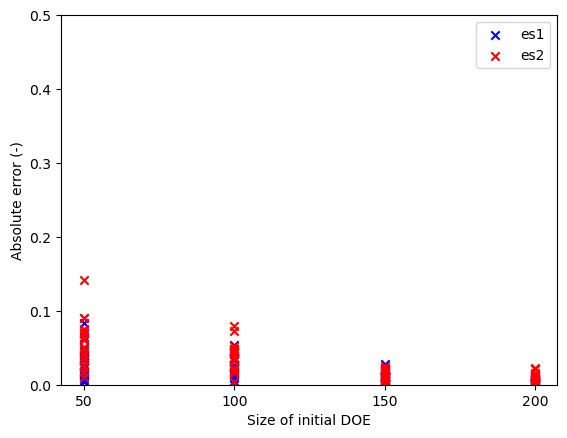

In [19]:
# 3-BIN ADOE: IMPACT OF DIFFERENT INITIAL SIZE ON ERROR 

plt.scatter(np.zeros_like(BIN_es1[0:19])+50,BIN_es1[0:19], c='b', marker='x', label='es1')
plt.scatter(np.zeros_like(BIN_es1[0:19])+50,BIN_es2[0:19], c='r', marker='x', label='es2')
plt.scatter(np.zeros_like(BIN_es1[0:19])+100,BIN_es1[20:39], c='b', marker='x')
plt.scatter(np.zeros_like(BIN_es1[0:19])+100,BIN_es2[20:39], c='r', marker='x')
plt.scatter(np.zeros_like(BIN_es1[0:19])+150,BIN_es1[40:59], c='b', marker='x')
plt.scatter(np.zeros_like(BIN_es1[0:19])+150,BIN_es2[40:59], c='r', marker='x')
plt.scatter(np.zeros_like(BIN_es1[0:19])+200,BIN_es1[60:79], c='b', marker='x')
plt.scatter(np.zeros_like(BIN_es1[0:19])+200,BIN_es2[60:79], c='r', marker='x')
plt.xticks(np.arange(50, 201, step=50))  # Set label locations.
plt.xlabel('Size of initial DOE')
plt.ylabel('Absolute error (-)')
ax = plt.gca()
ax.set_ylim([0, 0.5])
plt.legend(loc='upper right')
plt.show()

# RIGID DOE

In [12]:
def DOE(ini_size):
    
    # INITIATE USING LHS SAMPLES 
    elmn = ini_size
    S_X1 = 0
    S_X2 = 0
    S_X3 = 0
    X_train = latin.sample(problem,ini_size,seed=None)
    Y_train = Ishigami.evaluate(X_train)
    kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
    GP_init = gaussian_process.fit(X_train, Y_train)
    X_ind = saltelli.sample(problem,1024)
    Y_ind = GP_init.predict(X_ind)
    Si = sobol.analyze(problem, Y_ind)
    S_X1=Si['S1'][0] 
    S_X2=Si['S1'][1]
    S_X3=Si['S1'][2]

    e_SX1 = np.abs(groundtruth_Si['S1'][0]-S_X1)
    e_SX2 = np.abs(groundtruth_Si['S1'][1]-S_X2)
    e_SX3 = np.abs(groundtruth_Si['S1'][2]-S_X3)
    
    result = []
    result.append(elmn)
    result.append(e_SX1)
    result.append(e_SX2)
    result.append(e_SX3)

    return result

In [13]:
# DOE: SCRIPT TO DETERMINE IMPACT OF SET SIZE

DOE_nel = []
DOE_es1 = []
DOE_es2 = []
DOE_es3 = []
sol = []

start_size = [50,100,150,200]
for n in start_size:
    i = 1
    for i in range(1,21):
        sol = DOE(n)
        DOE_nel.append(sol[-4])
        DOE_es1.append(sol[-3])
        DOE_es2.append(sol[-2])
        DOE_es3.append(sol[-1])
        i = i+1

C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\3398910909.py:13: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\3398910909.py:13: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\3398910909.py:13: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\3398910909.py:13: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\3398910909.py:13: DeprecationWarning: `salib.sample.saltelli` will be removed i

C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\3398910909.py:13: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\3398910909.py:13: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\3398910909.py:13: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\3398910909.py:13: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\3398910909.py:13: DeprecationWarning: `salib.sample.saltelli` will be removed i

C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\3398910909.py:13: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\3398910909.py:13: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\3398910909.py:13: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\3398910909.py:13: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_ind = saltelli.sample(problem,1024)
C:\Users\tbombern\AppData\Local\Temp\ipykernel_12308\3398910909.py:13: DeprecationWarning: `salib.sample.saltelli` will be removed i

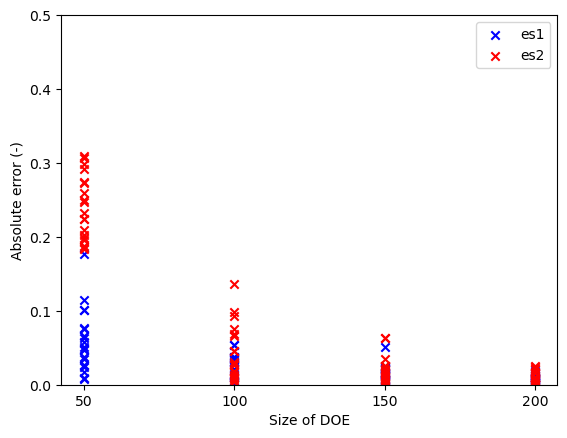

In [14]:
# DOE: IMPACT OF SET SIZE ON ERROR

plt.scatter(np.zeros_like(DOE_es1[0:19])+50,DOE_es1[0:19], c='b', marker='x', label='es1')
plt.scatter(np.zeros_like(DOE_es1[0:19])+50,DOE_es2[0:19], c='r', marker='x', label='es2')
plt.scatter(np.zeros_like(DOE_es1[0:19])+100,DOE_es1[20:39], c='b', marker='x')
plt.scatter(np.zeros_like(DOE_es1[0:19])+100,DOE_es2[20:39], c='r', marker='x')
plt.scatter(np.zeros_like(DOE_es1[0:19])+150,DOE_es1[40:59], c='b', marker='x')
plt.scatter(np.zeros_like(DOE_es1[0:19])+150,DOE_es2[40:59], c='r', marker='x')
plt.scatter(np.zeros_like(DOE_es1[0:19])+200,DOE_es1[60:79], c='b', marker='x')
plt.scatter(np.zeros_like(DOE_es1[0:19])+200,DOE_es2[60:79], c='r', marker='x')
plt.xticks(np.arange(50, 201, step=50))  # Set label locations.
plt.xlabel('Size of DOE')
plt.ylabel('Absolute error (-)')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_ylim([0, 0.5])
plt.show()